# 2D transform

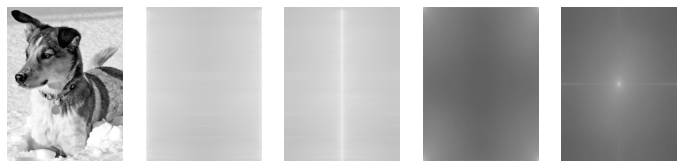

In [6]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import os
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18})

A = imread(os.path.join('..','DATA','dog.jpg'))
B = np.mean(A, -1); # Convert RGB to grayscale

fig,axs = plt.subplots(1,5)

# Plot image
img = axs[0].imshow(B)
img.set_cmap('gray')
axs[0].axis('off')

# Compute row-wise FFT

Cshift = np.zeros_like(B,dtype='complex_')
C = np.zeros_like(B,dtype='complex_')

for j in range(B.shape[0]):
    # fftshift: Shift the zero-frequency component
    # to the center of the spectrum.
    C[j,:] = np.fft.fft(B[j,:])
    Cshift[j,:] = np.fft.fftshift(C[j,:])

img = axs[2].imshow(np.log(np.abs(Cshift)))
img.set_cmap('gray')
axs[2].axis('off')
img = axs[1].imshow(np.log(np.abs(C)))
img.set_cmap('gray')
axs[1].axis('off')

# Compute column-wise FFT

D = np.zeros_like(C)
for j in range(C.shape[1]):
    D[:,j] = np.fft.fft(C[:,j])
img = axs[3].imshow(np.log(np.abs(D)))
img.set_cmap('gray')
axs[3].axis('off')
img = axs[4].imshow(np.fft.fftshift(np.log(np.abs(D))))
img.set_cmap('gray')
axs[4].axis('off')

plt.show()

In [5]:
import sys
print('Memory size of the image (bytes): ', sys.getsizeof(B))
print('Memory size of the 2D transformed image (bytes): ', sys.getsizeof(D))

Memory size of the image (bytes):  24000112
Memory size of the image (bytes):  112


In [14]:
# Much more efficient to use fft2
D = np.fft.fft2(B)
print('Memory size of the 2D transformed image (bytes): ', sys.getsizeof(D))

Memory size of the 2D transformed image (bytes):  112


# 2. Compression

20247.594796302375
34603.20483183541
102033.55809918485
320327.04330073454


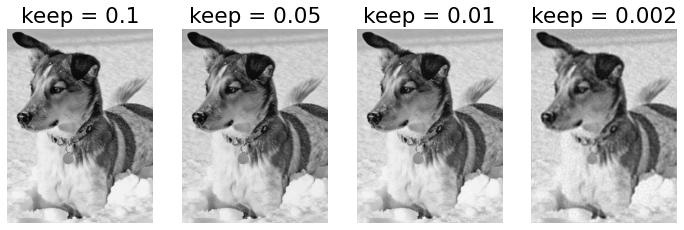

In [21]:
Bt = np.fft.fft2(B)
Btsort = np.sort(np.abs(Bt.reshape(-1))) # sort by magnitude

# Zero out all small coefficients and inverse transform
for i,keep in enumerate([0.1, 0.05, 0.01, 0.002]):
    thresh = Btsort[int(np.floor((1-keep)*len(Btsort)))]
    print(thresh)
    ind = np.abs(Bt)>thresh          # Find small indices
    Atlow = Bt * ind                 # Threshold small indices
    Alow = np.fft.ifft2(Atlow).real  # Compressed image
    plt.subplot(1,4,i+1)
    plt.imshow(Alow,cmap='gray')
    plt.axis('off')
    plt.title('keep = ' + str(keep))
plt.show()

# 3. Denoise

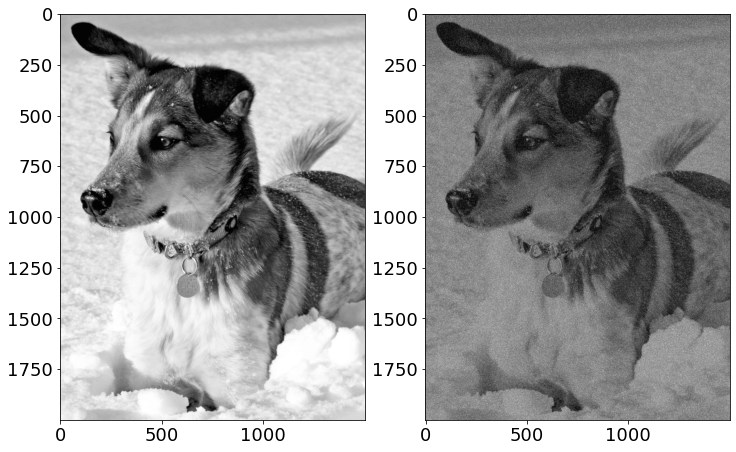

In [30]:
np.random.seed(68)
Bnoise = B + 200*np.random.randn(*B.shape).astype('uint8') # Add some noise
plt.subplot(1,2,1)
plt.imshow(B,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Bnoise,cmap='gray')

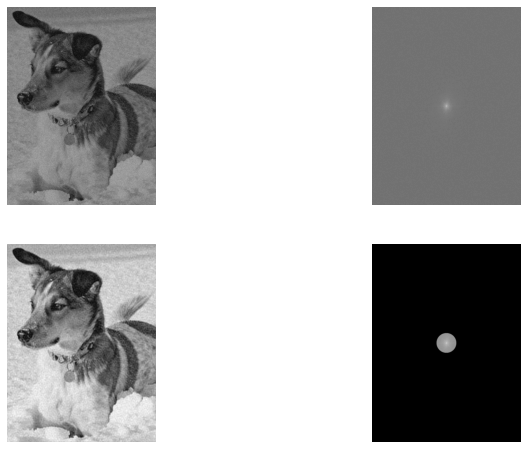

In [35]:
Bt = np.fft.fft2(Bnoise)
Btshift = np.fft.fftshift(Bt)
F = np.log(np.abs(Btshift)+1) # Put FFT on log scale

fig,axs = plt.subplots(2,2)

axs[0,0].imshow(Bnoise,cmap='gray')
axs[0,0].axis('off')

axs[0,1].imshow(F,cmap='gray')
axs[0,1].axis('off')

nx,ny = B.shape
X,Y = np.meshgrid(np.arange(-ny/2+1,ny/2+1),np.arange(-nx/2+1,nx/2+1))
# xgrid = np.fft.ifftshift(np.arange(-nx/2+1,nx/2+1))
# ygrid = np.fft.ifftshift(np.arange(-ny/2+1,ny/2+1))
# X,Y = np.meshgrid(ygrid,xgrid)
R2 = np.power(X,2) + np.power(Y,2)
ind = R2 < 100**2
Btshiftfilt = Btshift * ind
Ffilt = np.log(np.abs(Btshiftfilt)+1) # Put FFT on log scale

axs[1,1].imshow(Ffilt,cmap='gray')
axs[1,1].axis('off')

Btfilt = np.fft.ifftshift(Btshiftfilt)
Bfilt = np.fft.ifft2(Btfilt).real
axs[1,0].imshow(Bfilt,cmap='gray')
axs[1,0].axis('off')

plt.show()

# 4.Wavelet

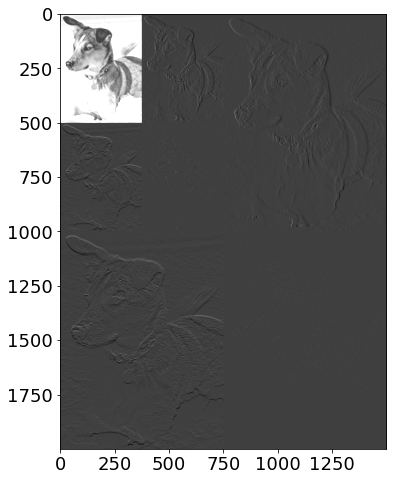

In [37]:
## Wavelet decomposition (2 level)
import pywt
n = 2
w = 'db1'
coeffs = pywt.wavedec2(B,wavelet=w,level=n)

# normalize each coefficient array
coeffs[0] /= np.abs(coeffs[0]).max()
for detail_level in range(n):
    coeffs[detail_level + 1] = [d/np.abs(d).max() for d in coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(coeffs)



plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)
plt.show()

# 5. Wavelet Compression
## Wavelet Compression

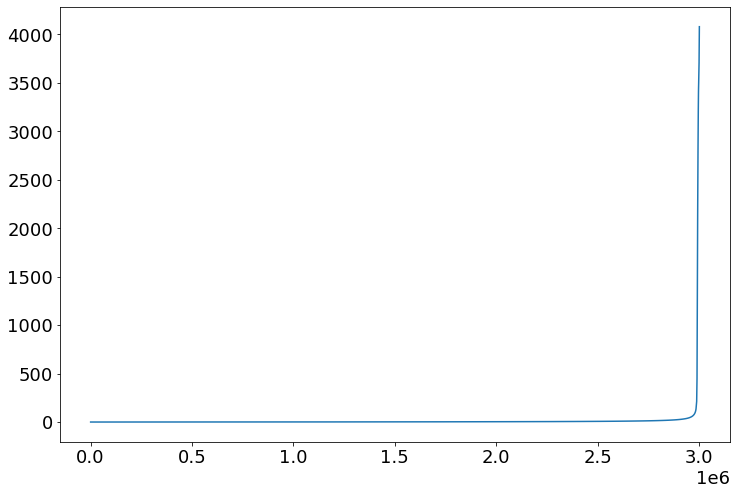

1.6666666666666667
18.91666666666667
68.62500000000003
3538.1875000000014


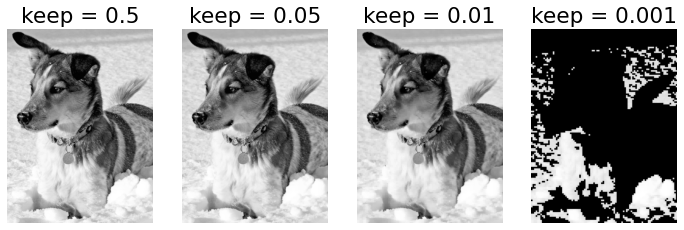

In [45]:
n = 4
w = 'db1'
coeffs = pywt.wavedec2(B,wavelet=w,level=n)

coeff_arr, _ = pywt.coeffs_to_array(coeffs)

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
plt.plot(Csort)
plt.show()
for i,keep in enumerate([0.5, 0.05, 0.01, 0.001]):
    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices
    print(thresh)
    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2')

    # Plot reconstruction
    Arecon = pywt.waverec2(coeffs_filt,wavelet=w)
    plt.subplot(1,4,i+1)
    plt.imshow(Arecon.astype('uint8'),cmap='gray')
    plt.axis('off')
    plt.title('keep = ' + str(keep))
plt.show()